# Understanding the KC-MBON syanpse structure and its postsynaptic specificity

### Import neccesary library modules now

In [1]:
import navis
import fafbseg
import flybrains

In [2]:
import numpy as np
import seaborn as sns
import itertools
import pandas as pd
from tqdm import tqdm
from functools import reduce

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
import scipy

In [5]:
import networkx as nx

In [6]:
label_fontsize = 16 
title_fontsize = 18

In [7]:
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer, set_flywireviewerstate

In [8]:
import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC
from navis.interfaces.neuprint import fetch_adjacencies, fetch_synapse_connections

In [9]:
from pyroglancer.layers import create_nglayer, setlayerproperty
from pyroglancer.ngviewer import openviewer, closeviewer,setviewerstate, get_ngscreenshot
from pyroglancer.ngspaces import create_ngspace
from pyroglancer.createconfig import createconfig

In [10]:
import matplotlib.pyplot as plt

# This makes it so the PDF export works
import matplotlib as mpl
mpl.rcParams['pdf.use14corefonts']=True
mpl.rcParams['font.sans-serif'] = ['Helvetica',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Computer Modern Sans Serif',
                                   'Lucida Grande',
                                   'Verdana',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',                                          
                                   'Avant Garde',
                                   'sans-serif']
mpl.rcParams['font.size'] = 11

In [11]:
from matplotlib.colors import rgb2hex, to_rgb

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
figwidth_size = 5
figheigth_size = 5

In [14]:
#navis display options for frontal view..
elev = -180
azim = -90
dist = 6

In [15]:
# This is to get stuff from csvs in github..
import requests
import os
from io import StringIO

# Need to pass Github token -> private repository
token = os.environ['GITHUB_PAT']
session = requests.session()
headers={'Authorization': f'token {token}', 'Accept': 'application/vnd.github.v3.raw'}

def fetch_csv(url):
    """Fetch and parse csv from private repository."""
    response = session.get(url, headers=headers)
    data = StringIO(response.text)
    return pd.read_csv(data, index_col=0)

In [16]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [17]:
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/sri/Downloads/windy-raceway-269415-23746907ea2d.json', scope)
gc = gspread.authorize(credentials)

In [18]:
settings = fetch_csv('https://raw.githubusercontent.com/jagannathancolabs/2022_postsynapticplasticity/main/settings/color_maps.csv')
glob_colors = settings.hex.to_dict()
glob_colors = {c: to_rgb(v.strip()) for c, v in glob_colors.items()}

### Set configurations to fetch from data from neuprint

In [19]:
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.2.1')

In [20]:
client

Client("https://neuprint.janelia.org", "hemibrain:v1.2.1")

### Get KC neurons from hemibrain

In [21]:
kcneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type="^KC.*",regex=True)) #get some KC type neurons..

In [22]:
kcbodyidList = kcneurons_df[['bodyId']]

In [23]:
print('number of KC neurons: ', len(kcbodyidList))

number of KC neurons:  1927


In [24]:
kcneurons_df.type.unique()

array(['KCab-m', 'KCab-c', 'KCab-s', 'KCg-m', 'KCab-p', "KCa'b'-ap2",
       "KCa'b'-m", "KCa'b'-ap1", 'KCg-d', 'KCg-t', 'KCg-s4', 'KCg-s1',
       'KCg-s3', 'KCg-s2'], dtype=object)

In [25]:
mb_rois = ["b'L(L)", "b'L(R)", #betaprimelobe
           'bL(L)', 'bL(R)',   #betalobe
           'gL(L)', 'gL(R)',   #gammalobe
           "a'L(L)", "a'L(R)", #alphaprimelobe
           'aL(L)', 'aL(R)',   #alphalobe
          ]

In [26]:
def get_usablecks(neuprinttargetmbon):
    #Identify the KCs that are actually connected to the specific type MBON..
    
    #Step1: fetch all the information about the specific type MBON..
    mbonneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type=neuprinttargetmbon,regex=True))
    mbonbodyidList = mbonneurons_df[['bodyId']]
    
    print('number of mbon neurons of type --',neuprinttargetmbon, '--: ', len(mbonbodyidList))
    
    #Step2: get the number of connections from all the KCs to the specific type MBON..
    neuron_df, conn_df = neu.queries.fetch_adjacencies(sources=kcbodyidList,targets=mbonbodyidList,rois = mb_rois)
    conn_df = neu.merge_neuron_properties(neuron_df, conn_df, ['type', 'instance'])
    conn_df.drop(['instance_pre', 'instance_post'], inplace=True, axis=1)
    print('mbon neurons of type being analysed: ', np.unique(conn_df.type_post))
    
    #Step3: identify only the KCs that are connected to the specific type MBON..
    usablekcbodyidList = conn_df.bodyId_pre.unique()
    
    print('number of kc neurons that are connected to target mbon: ', len(usablekcbodyidList))
    print('kc neuron types that are connected to target mbon: ', conn_df.type_pre.unique())
    #print('MBON neurons that are under investigation: ', conn_df.type_post.unique())
    
    
    #Step4: Just check if the number of inputs to the specific type MBON can be normalised..
    mbon_inputs = conn_df.groupby(['bodyId_pre','bodyId_post'], as_index=False)['weight'].sum()
    mbon_inputs['nSyn'] = mbon_inputs.index.map(lambda x: \
                                            (mbon_inputs.weight[x]/sum(mbon_inputs.weight[mbon_inputs.bodyId_post == mbon_inputs.bodyId_post[x]].values)))

    mbon_inputs['nSyn'] = 100*mbon_inputs['nSyn']
    
    usablembonbodyidList = conn_df.bodyId_post.unique()
    
    # check to see if normalisation happens wrt to the postsynapse
    norm_check = np.sum(mbon_inputs[mbon_inputs.bodyId_post == usablembonbodyidList[0]]['nSyn'])
    
    if np.round(norm_check) != 100:
        print('normalisation check: ', norm_check)
        
    
    print('connected to kcs: ', usablembonbodyidList)
    print('mbons not connected to kcs: ', list(set(mbonbodyidList['bodyId']) - set(usablembonbodyidList)))
    
    return usablekcbodyidList

In [27]:
def get_mbonspecificity(neuprinttargetmbon, usablekcbodyidList, literaturetargetmbon):
    
    #Step1: identify the synaptic connections from the relevant KCs to all downstream neurons(including the specific type MBON)..
    synconn_df = fetch_synapse_connections(source_criteria=usablekcbodyidList,target_criteria=None,
                                           synapse_criteria=SC(rois=mb_rois, primary_only=True))
    
    kc_downstreamlist = [synconn_df.bodyId_pre.unique(), synconn_df.bodyId_post.unique()]
    kc_downstreamlist = list(itertools.chain(*kc_downstreamlist))
    
    print('candidate neurons downstream of KCs are: ', len(kc_downstreamlist))
    
    
    #Step2: get the properties of all the neurons downstream of KCs..
    kcdownstreamneurons_df, _ = neu.fetch_neurons(NC(bodyId = kc_downstreamlist))
    
    #print('candidate neuron types downstream of KCs are: ', len(kcdownstreamneurons_df.type.unique()))
    
    bodyidtype_map = dict(kcdownstreamneurons_df[['bodyId', 'type']].values)
    
    synconn_df['bodyId_pretype'] = synconn_df.bodyId_pre.map(bodyidtype_map)
    synconn_df['bodyId_posttype'] = synconn_df.bodyId_post.map(bodyidtype_map)
    
    
    #Step3: get a map of the presynaptic locations by the different types of neurons connected on the post-synpatic site..
    prepostsyn_df = synconn_df.copy()
    
    prepostsyn_df['presyn_loc'] = synconn_df['x_pre'].astype(str) + ',' + synconn_df['y_pre'].astype(str) + ',' + synconn_df['z_pre'].astype(str)
    prepostsyn_df['postsyn_loc'] = synconn_df['x_post'].astype(str) + ',' + synconn_df['y_post'].astype(str) + ',' + synconn_df['z_post'].astype(str)

    prepostsyn_df = prepostsyn_df.drop(columns=['x_pre','y_pre','z_pre',
                                                'x_post','y_post','z_post',
                                                'roi_pre','roi_post',
                                                'confidence_pre','confidence_post',])
    
    prepostsyn_df['bodyId_posttype'] = prepostsyn_df['bodyId_posttype'].replace(celltypeliterature_map)
    
    grouped_df = prepostsyn_df.groupby(['presyn_loc','bodyId_posttype']).size().reset_index()
    grouped_df.rename(columns={0:'count'}, inplace=True)
    grouped_df = grouped_df.set_index(['presyn_loc', 'bodyId_posttype'])
    
    #grouped_df.iloc[grouped_df.index.get_level_values('presyn_loc') == '14242,28531,7904']
    
    
    #Step4: get a dataframe for each of the presynaptic locations (that contain target mbon) categorise the different types of neurons connected on the post-synpatic site..
    #here, the columns are..
    #targetmbon (count of postsynaptic neurons of target mbon)
    #MBONxx (count of postsynaptic neurons of any mbon, including target mbon)
    #total (total count of postsynaptic neurons of any type)
    #MBON_diff (MBONxx - targetmbon)
    cols = ['presyn_loc', literaturetargetmbon, 'MBONxx', 'total']
    
    print('literaturetargetmbon is :', literaturetargetmbon)
    
    tempsynconnlist = []
    for tempsynindex, tempsynconn_df in tqdm(grouped_df.groupby(level=0)):
        tempsynconn_df = tempsynconn_df.reset_index()
        if literaturetargetmbon in tempsynconn_df['bodyId_posttype'].values:
            tempsynconnlist.append([tempsynindex, tempsynconn_df[tempsynconn_df.bodyId_posttype == literaturetargetmbon]['count'].values[0], 
                                    np.sum(tempsynconn_df[tempsynconn_df['bodyId_posttype'].str.contains('MBON')]['count']),
                                    np.sum(tempsynconn_df['count'])])
            
    allsynconn_df = pd.DataFrame(tempsynconnlist, columns=cols)
    allsynconn_df['MBON_diff'] = allsynconn_df['MBONxx'] - allsynconn_df[literaturetargetmbon]
    
    totaltargetmbon_synapses = np.sum(allsynconn_df['MBON_diff'] >=0)
    
    
    #Step5: get a dataframe for the target mbon and summarise the different types of neurons connected on the post-synpatic site..
    #here, the columns are..
    #targetname (name of postsynaptic neurons of target mbon)
    #onlytargetmbon (count of postsynaptic sites containing only target mbon)
    #with1MBONxx (count of postsynaptic sites with MBON_diff == 1)
    #with2ormoreMBONxx (count of postsynaptic sites with MBON_diff >= 2)
    #overallsynapses (count of all postsynaptic sites)
    
    cols = ['targetname', 'onlytargetmbon', 'with1MBONxx', 'with2ormoreMBONxx', 'overallsynapticsites']
    
    mbonspecific_df = pd.DataFrame([[literaturetargetmbon,
                                     np.sum(allsynconn_df['MBON_diff'] == 0), 
                                     np.sum(allsynconn_df['MBON_diff'] == 1),
                                     np.sum(allsynconn_df['MBON_diff'] >= 2),
                                     np.sum(allsynconn_df['MBON_diff'] >=0)]],columns = cols)
    
    norm_mbonspecific_df = pd.DataFrame([[literaturetargetmbon,
                                         (np.sum(allsynconn_df['MBON_diff'] == 0))/totaltargetmbon_synapses, 
                                          (np.sum(allsynconn_df['MBON_diff'] == 1))/totaltargetmbon_synapses,
                                         (np.sum(allsynconn_df['MBON_diff'] >= 2))/totaltargetmbon_synapses,
                                         (np.sum(allsynconn_df['MBON_diff'] >=0))/totaltargetmbon_synapses]], columns=cols)

    
    return mbonspecific_df, norm_mbonspecific_df, grouped_df, allsynconn_df

In [28]:
def plot_kcoutputnumbers(literaturetargetmbon, allsynconn_df):
    fig = plt.figure(figsize=(6, 6))
    gs_main = gridspec.GridSpec(1, 1)
    gs_main.update(wspace=0, hspace=0)

    #set up the legend..
    gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
    ax = fig.add_subplot(gs[0])

    ax = sns.histplot(data=allsynconn_df, x='total', stat='probability', bins = np.unique(allsynconn_df['total'])-0.5, ax=ax)

    ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
    plt.box(False)
    ax.grid(True)
    loc, labels = plt.xticks()
    ax.set_xticks(np.arange(1,np.max(allsynconn_df['total']),1))
    ax.set_xlabel('number of postsynaptic neurons per KC presynapse',fontsize=label_fontsize-2, weight = 'bold')
    ax.set_ylabel('proportion',fontsize=label_fontsize-2, weight = 'bold')
    ax.set_title(literaturetargetmbon+'\n', fontsize=label_fontsize, fontweight = 'bold')

    plt.savefig('figures/' + literaturetargetmbon + '.png', dpi=300, bbox_inches='tight')

### mbons of interest

In [29]:
papermbons_df = pd.DataFrame([['MBON01','MBON-γ5β′2a','MBON-M6'],
                              ['MBON03','MBON-β′2mp','MBON-M4'],
                              [['MBON16','MBON17'],'MBON-α′3','MBON-α′3']],columns = ['em', 'lm', 'literature'])
papermbons_df

,em,lm,literature
0,MBON01,MBON-γ5β′2a,MBON-M6
1,MBON03,MBON-β′2mp,MBON-M4
2,"[MBON16, MBON17]",MBON-α′3,MBON-α′3


In [30]:
# allmbonList = ['MBON01', 'MBON02', 'MBON03',      'MBON04', 'MBON05', 
#                'MBON06', 'MBON07', 'MBON09',      'MBON10', 'MBON11', 
#                'MBON12', 'MBON13', 'MBON14',      'MBON15', 'MBON15-like', 
#                'MBON16', 'MBON17', 'MBON17-like', 'MBON18', 'MBON19', 
#                'MBON20', 'MBON21', 'MBON22',      'MBON23', 'MBON24', 
#                'MBON25', 'MBON26', 'MBON27',      'MBON28', 'MBON29', 
#                'MBON30', 'MBON31', 'MBON32',      'MBON33', 'MBON34',
#                'MBON35']

In [31]:
if os.path.exists('data/allmbonspecific.csv'):
    allmbonspecific_df = pd.read_csv('data/allmbonspecific.csv')
    allnorm_mbonspecific_df = pd.read_csv('data/allnorm_mbonspecific.csv')
else:
    allmbonspecific_df = pd.DataFrame(columns=['targetname','onlytargetmbon','with1MBONxx','with2ormoreMBONxx','overallsynapticsites'])
    allnorm_mbonspecific_df = pd.DataFrame(columns=['targetname','onlytargetmbon','with1MBONxx','with2ormoreMBONxx','overallsynapticsites'])

In [32]:
synpasecount_cobodyids_df = pd.DataFrame([])

In [33]:
celltypeliterature_map = {}

In [34]:
for dicttargetidx in range(len(papermbons_df)):
    dicttargetmbonList = papermbons_df['em'][dicttargetidx]
    dictliteraturetargetmbon = papermbons_df['literature'][dicttargetidx]
    
    if isinstance(dicttargetmbonList, list):
        if not celltypeliterature_map:
            celltypeliterature_map = dict.fromkeys(dicttargetmbonList, dictliteraturetargetmbon)
        else:
            celltypeliterature_map = {**celltypeliterature_map, **dict.fromkeys(dicttargetmbonList, dictliteraturetargetmbon)}
    else:
        if not celltypeliterature_map:
            celltypeliterature_map = {dicttargetmbonList :dictliteraturetargetmbon}
        else:
            celltypeliterature_map[dicttargetmbonList] = dictliteraturetargetmbon

In [35]:
print(celltypeliterature_map)

{'MBON01': 'MBON-M6', 'MBON03': 'MBON-M4', 'MBON16': 'MBON-α′3', 'MBON17': 'MBON-α′3'}


neuprint target mbons to be analysed : MBON01
literature target mbons to be analysed : MBON-M6
number of mbon neurons of type -- MBON01 --:  2


INFO - 2022-01-13 12:57:26,866 - utils - NumExpr defaulting to 8 threads.


mbon neurons of type being analysed:  ['MBON01']
number of kc neurons that are connected to target mbon:  984
kc neuron types that are connected to target mbon:  ['KCg-m' "KCa'b'-ap2" "KCa'b'-ap1" "KCa'b'-m" 'KCg-d' 'KCg-t' 'KCg-s1'
 'KCg-s3' 'KCg-s2']
connected to kcs:  [612371421 673509195]
mbons not connected to kcs:  []


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

candidate neurons downstream of KCs are:  3157
literaturetargetmbon is : MBON-M6


100%|██████████| 200836/200836 [01:59<00:00, 1676.40it/s]


neuprint target mbons to be analysed : MBON03
literature target mbons to be analysed : MBON-M4
number of mbon neurons of type -- MBON03 --:  2
mbon neurons of type being analysed:  ['MBON03']
number of kc neurons that are connected to target mbon:  344
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCg-m']
connected to kcs:  [487925037 612738462]
mbons not connected to kcs:  []


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

candidate neurons downstream of KCs are:  2078
literaturetargetmbon is : MBON-M4


100%|██████████| 76575/76575 [00:46<00:00, 1633.46it/s]


neuprint target mbons to be analysed : ['MBON16', 'MBON17']
literature target mbons to be analysed : MBON-α′3
number of mbon neurons of type -- ['MBON16', 'MBON17'] --:  2
mbon neurons of type being analysed:  ['MBON16' 'MBON17']
number of kc neurons that are connected to target mbon:  334
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCg-m' 'KCab-p']
connected to kcs:  [ 673366098 5812981264]
mbons not connected to kcs:  []


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

candidate neurons downstream of KCs are:  1715
literaturetargetmbon is : MBON-α′3


100%|██████████| 74650/74650 [00:40<00:00, 1829.05it/s]


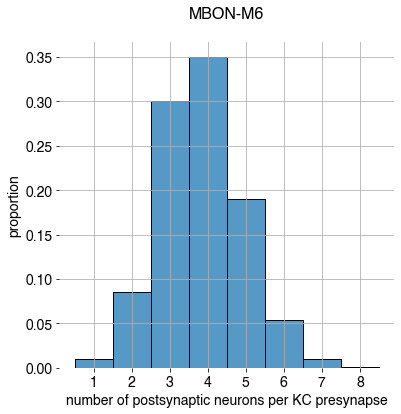

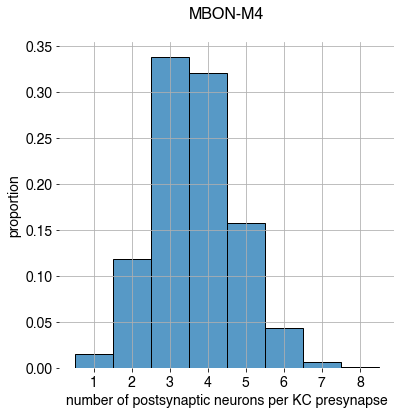

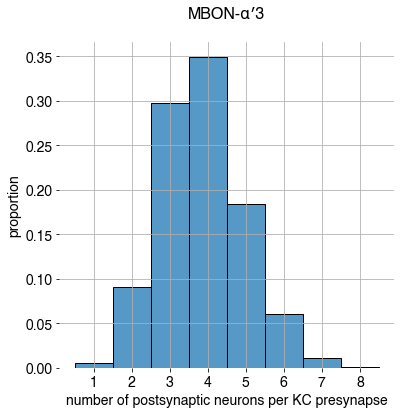

In [36]:
for targetidx in range(len(papermbons_df)):
    
    neuprinttargetmbonList = papermbons_df['em'][targetidx]
    print('neuprint target mbons to be analysed :',neuprinttargetmbonList)
    literaturetargetmbon = papermbons_df['literature'][targetidx]
    print('literature target mbons to be analysed :',literaturetargetmbon)
     
    usablekcbodyidList = get_usablecks(neuprinttargetmbonList)
    
    mbonspecific_df, norm_mbonspecific_df, grouped_df, allsynconn_df = get_mbonspecificity(neuprinttargetmbonList, usablekcbodyidList, literaturetargetmbon)
    
    plot_kcoutputnumbers(literaturetargetmbon, allsynconn_df)
    
    allmbonspecific_df = allmbonspecific_df.append(mbonspecific_df)
    allnorm_mbonspecific_df = allnorm_mbonspecific_df.append(norm_mbonspecific_df)
        
    #get dataframe for counting different neuron types that are along with the specific mbon type (co-bodyids)..
    locbytypecount_df = grouped_df.unstack()
    synapsecountbytype_df = locbytypecount_df.sum(axis=0)
    synapsecountbytype_df = synapsecountbytype_df.reset_index(level=[0,1])
    synapsecountbytype_df = synapsecountbytype_df.rename({'level_0': 'target_MBON', 'bodyId_posttype': 'co_bodyid_type', 0: 'synapse_count'}, axis=1) 
    synapsecountbytype_df['target_MBON'] = literaturetargetmbon
    synpasecount_cobodyids_df = synpasecount_cobodyids_df.append(synapsecountbytype_df)
    
    allmbonspecific_df.to_csv('data/allmbonspecific.csv', index=False)
    allnorm_mbonspecific_df.to_csv('data/allnorm_mbonspecific.csv', index=False)

In [37]:
allmbonspecific_df = allmbonspecific_df.sort_values(by=['targetname'], ascending=True)
allmbonspecific_df = allmbonspecific_df.reset_index()
allmbonspecific_df.head()

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,1,MBON-M4,10130,3128,246,13504
1,0,MBON-M4,10130,3128,246,13504
2,0,MBON-M6,21139,5270,424,26833
3,0,MBON-M6,21139,5270,424,26833
4,2,MBON-α′3,3610,2581,89,6280


In [38]:
allnorm_mbonspecific_df = allnorm_mbonspecific_df.sort_values(by=['targetname'], ascending=True)
allnorm_mbonspecific_df = allnorm_mbonspecific_df.reset_index()
allnorm_mbonspecific_df.head()

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,1,MBON-M4,0.750148,0.231635,0.018217,1.0
1,0,MBON-M4,0.750148,0.231635,0.018217,1.0
2,0,MBON-M6,0.787799,0.196400,0.015801,1.0
3,0,MBON-M6,0.787799,0.196400,0.015801,1.0
4,2,MBON-α′3,0.574841,0.410987,0.014172,1.0


In [39]:
synpasecount_cobodyids_df

,target_MBON,co_bodyid_type,synapse_count
0,MBON-M6,5-HTPMPD01,1.0
1,MBON-M6,ALBN1,1.0
2,MBON-M6,ALIN1,10.0
3,MBON-M6,AOTU008_a,7.0
4,MBON-M6,AOTU019,8.0
...,...,...,...
171,MBON-α′3,TuBu10,1.0
172,MBON-α′3,VES079,1.0
173,MBON-α′3,WEDPN4,11.0
174,MBON-α′3,mAL6,5.0


In [40]:
#reshape dataframe so we have co_bodyid by specific mbon type, the values would be counts where they cooccur on the post-synaptic site..
cobodyid_by_mbontype_df = synpasecount_cobodyids_df.pivot(index = 'co_bodyid_type', columns='target_MBON',values='synapse_count')
cobodyid_by_mbontype_df = cobodyid_by_mbontype_df.reset_index()
cobodyid_by_mbontype_df = cobodyid_by_mbontype_df.set_index('co_bodyid_type')
cobodyid_by_mbontype_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
5-HTPMPD01,1.0,1.0,1.0
ALBN1,NaN,1.0,NaN
ALIN1,15.0,10.0,15.0
AOTU008_a,6.0,7.0,6.0
AOTU019,NaN,8.0,NaN
...,...,...,...
mAL6,5.0,5.0,5.0
mALB1,1.0,2.0,1.0
mALD2,NaN,14.0,NaN


In [41]:
normcobodyid_by_mbontype_df = cobodyid_by_mbontype_df.copy()
cols = ['MBON-M4', 'MBON-M6', 'MBON-α′3']
normcobodyid_by_mbontype_df[cols] = 100*normcobodyid_by_mbontype_df[cols] / normcobodyid_by_mbontype_df[cols].sum()

In [42]:
normcobodyid_by_mbontype_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
5-HTPMPD01,0.000399,0.000150,0.000409
ALBN1,NaN,0.000150,NaN
ALIN1,0.005987,0.001504,0.006142
AOTU008_a,0.002395,0.001053,0.002457
AOTU019,NaN,0.001203,NaN
...,...,...,...
mAL6,0.001996,0.000752,0.002047
mALB1,0.000399,0.000301,0.000409
mALD2,NaN,0.002106,NaN


In [43]:
normcobodyid_by_mbontype_df['MBON-M4'].sum()

100.0

In [44]:
top_mbonm4 = normcobodyid_by_mbontype_df.sort_values(by=['MBON-M4'], ascending=False)
top_mbonm6 = normcobodyid_by_mbontype_df.sort_values(by=['MBON-M6'], ascending=False)
top_mbonα3 = normcobodyid_by_mbontype_df.sort_values(by=['MBON-α′3'], ascending=False)

In [45]:
topneurontypes = reduce(np.union1d, (top_mbonm4.index[0:9].values, top_mbonm6.index[0:9].values, 
                    top_mbonα3.index[0:9].values))

In [46]:
topneurontypes

array(['APL', 'DPM', "KCa'b'-ap1", "KCa'b'-ap2", "KCa'b'-m", 'KCg-d',
       'KCg-m', 'MBON-M4', 'MBON-M6', 'MBON-α′3', 'MBON05', 'MBON09',
       'PAM06_a'], dtype=object)

In [47]:
topneurontypes_dict = dict(zip(topneurontypes, topneurontypes))

In [48]:
topneurontypes_dict

{'APL': 'APL',
 'DPM': 'DPM',
 "KCa'b'-ap1": "KCa'b'-ap1",
 "KCa'b'-ap2": "KCa'b'-ap2",
 "KCa'b'-m": "KCa'b'-m",
 'KCg-d': 'KCg-d',
 'KCg-m': 'KCg-m',
 'MBON-M4': 'MBON-M4',
 'MBON-M6': 'MBON-M6',
 'MBON-α′3': 'MBON-α′3',
 'MBON05': 'MBON05',
 'MBON09': 'MBON09',
 'PAM06_a': 'PAM06_a'}

In [49]:
normcobodyid_by_mbontype_df.index = normcobodyid_by_mbontype_df.index.map(lambda x: topneurontypes_dict.get(x, 'Others'))

In [50]:
normcobodyid_by_mbontype_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
Others,0.000399,0.000150,0.000409
Others,NaN,0.000150,NaN
Others,0.005987,0.001504,0.006142
Others,0.002395,0.001053,0.002457
Others,NaN,0.001203,NaN
...,...,...,...
Others,0.001996,0.000752,0.002047
Others,0.000399,0.000301,0.000409
Others,NaN,0.002106,NaN


In [51]:
sorted_df = normcobodyid_by_mbontype_df.sort_values('MBON-M4', ascending = False)
sorted_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
KCa'b'-ap2,14.760027,5.397259,15.121374
KCa'b'-m,13.419259,3.164118,13.688146
KCa'b'-ap1,9.584557,3.655024,9.478141
DPM,7.801922,5.823945,7.839757
APL,6.789261,6.305375,6.774664
...,...,...,...
Others,NaN,0.000150,NaN
Others,NaN,0.000150,NaN
Others,NaN,0.002106,NaN


In [52]:
sorted_df = sorted_df[sorted_df.index != 'Others']

In [53]:
sorted_df = sorted_df.append(pd.Series(100-sorted_df.sum(), name='others'))
sorted_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
KCa'b'-ap2,14.760027,5.397259,15.121374
KCa'b'-m,13.419259,3.164118,13.688146
KCa'b'-ap1,9.584557,3.655024,9.478141
DPM,7.801922,5.823945,7.839757
APL,6.789261,6.305375,6.774664
MBON-M4,5.453283,1.722533,5.524480
MBON09,3.939679,3.461760,3.936872
PAM06_a,3.036786,0.923908,3.084307
MBON-α′3,2.963741,1.010238,3.042948


In [54]:
sorted_df['MBON-M4'].sum()

100.0

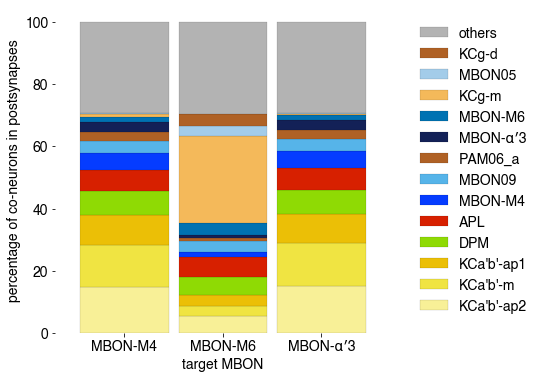

In [55]:
fig = plt.figure(figsize=(6, 6))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])
ax = sorted_df.T.plot(kind='bar', stacked=True, ax = ax, color = glob_colors,
                     linewidth=0.1, width = 0.9, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', 
          bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize-2},frameon=False)

ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.box(False)
ax.grid(False)
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('target MBON',fontsize=label_fontsize-2, weight = 'bold')
ax.set_ylabel('percentage of co-neurons in postsynapses',fontsize=label_fontsize-2, weight = 'bold')
plt.savefig('figures/mbon_parsing_specificity.png', dpi=300, bbox_inches='tight')

In [ ]:
allmbonspecific_df

In [ ]:
allnorm_mbonspecific_df['nontargetmbon'] = allnorm_mbonspecific_df['overallsynapticsites']  - allnorm_mbonspecific_df['onlytargetmbon'] 

In [ ]:
allnorm_mbonspecific_df

In [ ]:
def repel_labels(ax, x, y, labels, selectedlabels = None, k=0.01):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        if label in selectedlabels:
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',color='#053CFF',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='#D72000'), )
        else:
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='#D72000'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    #ax.set_xlim([mins[0], maxs[0]])
    #ax.set_ylim([mins[1], maxs[1]])

In [ ]:
fig = plt.figure(figsize=(12, 12))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])

ax = sns.scatterplot('nontargetmbon', # Horizontal axis
                     'onlytargetmbon', # Vertical axis
                     data=allnorm_mbonspecific_df,
                     axes = ax,
                     color='#ADD8E6',
                     s=50,
                     linewidth = 1.5,
                     edgecolor='black') # size and dimension


# plotitems = ['MBON03', 'MBON16', 'MBON17']
plotitems = None

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xlabel('with non-targetmbon',fontsize=label_fontsize-2, weight = 'bold')
ax.set_ylabel('only containing targetmbon',fontsize=label_fontsize-2, weight = 'bold')
ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.subplots_adjust(wspace=0, hspace=0)
plt.box(False)
plt.grid(True)
sns.despine(trim=True)

repel_labels(ax = ax, x = allnorm_mbonspecific_df.nontargetmbon, y = allnorm_mbonspecific_df.onlytargetmbon, 
             labels = allnorm_mbonspecific_df.targetname, selectedlabels = paper_mbons, k = 0.04)

plt.savefig('figures/mbon_specificity.png', dpi=300, bbox_inches='tight')

In [ ]:
paper_mbons

### Get specificity across synaptic sets

In [ ]:
def get_closestdistance(targetmbon, usablekcbodyidList):
    
    #Step1: identify the synaptic connections from the specific type MBON to all upstream neurons including KCs..
    mbonsynconn_df = fetch_synapse_connections(source_criteria=None,target_criteria=targetmbon,
                                               synapse_criteria=SC(rois=mb_rois, primary_only=True))
    
    mbon_upstreamlist = [mbonsynconn_df.bodyId_pre.unique(), mbonsynconn_df.bodyId_post.unique()]
    mbon_upstreamlist = list(itertools.chain(*mbon_upstreamlist))
    
    print('candidate neurons upstream of ', targetmbon, 'are: ', len(mbon_upstreamlist))
    
    #Step2: get the properties of all the neurons upstream of mbons..
    mbonupstreamneurons_df, _ = neu.fetch_neurons(NC(bodyId = mbon_upstreamlist))
    #print('candidate neuron types upstream of MBONs are: ', len(mbonupstreamneurons_df.type.unique()))
    mbonupstreambodyidtype_map = dict(mbonupstreamneurons_df[['bodyId', 'type']].values)
    
    mbonsynconn_df['bodyId_pretype'] = mbonsynconn_df.bodyId_pre.map(mbonupstreambodyidtype_map)
    mbonsynconn_df['bodyId_posttype'] = mbonsynconn_df.bodyId_post.map(mbonupstreambodyidtype_map)
    
    #Step3: get a map of the postsynaptic locations by the different types of neurons connected on the pre-synpatic site..
    mbonprepostsyn_df = mbonsynconn_df.copy()
    mbonprepostsyn_df['presyn_loc'] = mbonsynconn_df['x_pre'].astype(str) + ',' + mbonsynconn_df['y_pre'].astype(str) + ',' + mbonsynconn_df['z_pre'].astype(str)
    mbonprepostsyn_df['postsyn_loc'] = mbonsynconn_df['x_post'].astype(str) + ',' + mbonsynconn_df['y_post'].astype(str) + ',' + mbonsynconn_df['z_post'].astype(str)
    mbonprepostsyn_df = mbonprepostsyn_df.drop(columns=['x_pre','y_pre','z_pre',
                                                        'x_post','y_post','z_post',
                                                        'roi_pre','roi_post',
                                                        'confidence_pre','confidence_post',])
    
    mbongrouped_df = mbonprepostsyn_df.groupby(['postsyn_loc','bodyId_pretype']).size().reset_index()
    mbongrouped_df.rename(columns={0:'count'}, inplace=True)
    mbongrouped_df = mbongrouped_df.set_index(['postsyn_loc', 'bodyId_pretype'])

    
    #Step4: prepare a dataframe of postsynaptic locations by the different types of neurons connected on the pre-synaptic site..
    postsynlocationsbypresyntype_df = mbongrouped_df.reset_index()
    postsynlocationsbypresyntype_df[['post_x', 'post_y', 'post_z']] = postsynlocationsbypresyntype_df['postsyn_loc'].str.split(',', expand=True)
    postsynlocationsbypresyntype_df[['post_x', 'post_y', 'post_z']] = postsynlocationsbypresyntype_df[['post_x', 'post_y', 'post_z']].astype(int)
    
#     #Step5: compute the euclidean distance between all pairs of postsynaptic locations..
#     distancemat = scipy.spatial.distance.cdist(postsynlocationsbypresyntype_df[['post_x','post_y','post_z']], 
#                                        postsynlocationsbypresyntype_df[['post_x','post_y','post_z']], metric='euclidean')
    
#     distance_df = pd.DataFrame(distancemat, index=postsynlocationsbypresyntype_df['postsyn_loc'], columns=postsynlocationsbypresyntype_df['postsyn_loc'])
    
#     closest_point = np.where(distance_df.eq(distance_df[distance_df != 0].min(),0),distance_df.columns,False)
#     closest_dist = np.where(distance_df.eq(distance_df[distance_df != 0].min(),0),distance_df.values,False)
    
#     # Remove false from the array and get the column names as list
#     postsynlocationsbypresyntype_df['closest_loc'] = [i[i.astype(bool)][0] for i in closest_point]
#     postsynlocationsbypresyntype_df[['close_x', 'close_y', 'close_z']] = postsynlocationsbypresyntype_df['closest_loc'].str.split(',', expand=True)
#     postsynlocationsbypresyntype_df[['close_x', 'close_y', 'close_z']] = postsynlocationsbypresyntype_df[['close_x', 'close_y', 'close_z']].astype(int)
    
#     postsynlocationsbypresyntype_df['closest_dist'] = [i[i.astype(bool)][0] for i in closest_dist]
    
#     # scale the voxel locations to raw nanometers
#     postsynlocationsbypresyntype_df['closest_dist_nm'] = (postsynlocationsbypresyntype_df['closest_dist']/125)*1000
    
#     euclideandistance_df = postsynlocationsbypresyntype_df[['bodyId_pretype', 'closest_dist_nm']]
#     euclideandistance_df['postsynaptictype'] = targetmbon

   
    postsynlocationsbykcpresyn_df = postsynlocationsbypresyntype_df[postsynlocationsbypresyntype_df.bodyId_pretype.str.match(r'(^KC.*)')==True]
    postsynlocationsbydanpresyn_df = postsynlocationsbypresyntype_df[((postsynlocationsbypresyntype_df.bodyId_pretype.str.match(r'(^PAM.*)')==True) |
                                                                      (postsynlocationsbypresyntype_df.bodyId_pretype.str.match(r'(^PPL.*)')==True))]
    
    
    #Step5: compute the euclidean distance between postsynaptic locations (which have kc as presynapse and dan as presynapse)..
    distancemat_kctodan = scipy.spatial.distance.cdist(postsynlocationsbykcpresyn_df[['post_x','post_y','post_z']], 
                                                       postsynlocationsbydanpresyn_df[['post_x','post_y','post_z']], metric='euclidean')
    
    distance_kctodan_df = pd.DataFrame(distancemat_kctodan, index=postsynlocationsbykcpresyn_df['postsyn_loc'], 
                                                            columns=postsynlocationsbydanpresyn_df['postsyn_loc'])
    
    postsynlocationsbykcpresyn_df['distance_kctodan'] = distance_kctodan_df.min(axis=1).values
    postsynlocationsbykcpresyn_df['closestpt_kctodan'] = distance_kctodan_df.idxmin(axis=1).values
    
    
    #Step6: compute the euclidean distance between postsynaptic locations (which have kc as presynapse and kc as presynapse)..
    distancemat_kctokc = scipy.spatial.distance.cdist(postsynlocationsbykcpresyn_df[['post_x','post_y','post_z']], 
                                                       postsynlocationsbykcpresyn_df[['post_x','post_y','post_z']], metric='euclidean')
    
    distance_kctokc_df = pd.DataFrame(distancemat_kctokc, index=postsynlocationsbykcpresyn_df['postsyn_loc'], 
                                                    columns=postsynlocationsbykcpresyn_df['postsyn_loc'])
    
    closest_point_kctokc = np.where(distance_kctokc_df.eq(distance_kctokc_df[distance_kctokc_df != 0].min(),0),distance_kctokc_df.columns,False)
    closest_dist_kctokc = np.where(distance_kctokc_df.eq(distance_kctokc_df[distance_kctokc_df != 0].min(),0),distance_kctokc_df.values,False)
    
    postsynlocationsbykcpresyn_df['distance_kctokc'] = [i[i.astype(bool)][0] for i in closest_dist_kctokc]
    postsynlocationsbykcpresyn_df['closestpt_kctokc'] = [i[i.astype(bool)][0] for i in closest_point_kctokc]
    
    
    #Step7: map a dataframe with the distances..
    postsynlocationsbykcpresyn_df['closestpttype_kctodan'] = postsynlocationsbykcpresyn_df['closestpt_kctodan'].map(postsynlocationsbypresyntype_df.set_index('postsyn_loc')['bodyId_pretype'])
    # scale the voxel locations to raw nanometers
    postsynlocationsbykcpresyn_df['distance_kctodan_nm'] = (postsynlocationsbykcpresyn_df['distance_kctodan']/125)*1000
    
    postsynlocationsbykcpresyn_df['closestpttype_kctokc'] = postsynlocationsbykcpresyn_df['closestpt_kctokc'].map(postsynlocationsbypresyntype_df.set_index('postsyn_loc')['bodyId_pretype'])
    postsynlocationsbykcpresyn_df['distance_kctokc_nm'] = (postsynlocationsbykcpresyn_df['distance_kctokc']/125)*1000
    
    plotsynlocationsdistance_df = postsynlocationsbykcpresyn_df[['postsyn_loc','bodyId_pretype','distance_kctodan_nm','distance_kctokc_nm']]
    statssynlocationsdistance_df = plotsynlocationsdistance_df.copy()
    statssynlocationsdistance_df['mbon_type'] = targetmbon
    
    plotsynlocationsdistance_df = plotsynlocationsdistance_df.melt(id_vars=["postsyn_loc", "bodyId_pretype"], var_name="type", value_name="distance")
    plotsynlocationsdistance_df['mbon_type'] = targetmbon
    
    return statssynlocationsdistance_df, plotsynlocationsdistance_df


In [ ]:
allplotsynlocationsdistance_df = pd.DataFrame([])
allstatssynlocationsdistance_df = pd.DataFrame([])

In [ ]:
for targetmbonList in paper_mbons:
    usablekcbodyidList = get_usablecks(targetmbonList)
    print('processing :', targetmbonList)
    statssynlocationsdistance_df, plotsynlocationsdistance_df = get_closestdistance(targetmbonList, usablekcbodyidList)
    allplotsynlocationsdistance_df = allplotsynlocationsdistance_df.append(plotsynlocationsdistance_df)
    allstatssynlocationsdistance_df = allstatssynlocationsdistance_df.append(statssynlocationsdistance_df)

In [ ]:
import pingouin as pg
from pingouin import ttest

In [ ]:
allstatssynlocationsdistance_df

In [ ]:
res_mbon03 = ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON03')]['distance_kctodan_nm'], 
                   allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON03')]['distance_kctokc_nm'], 
                   paired=True).round(3)

In [ ]:
res_mbon03

In [ ]:
ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON16')]['distance_kctodan_nm'], 
      allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON16')]['distance_kctokc_nm'], 
      paired=True).round(3)

In [ ]:
ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17')]['distance_kctodan_nm'], 
      allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17')]['distance_kctokc_nm'], 
      paired=True).round(3)

In [ ]:
ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17-like')]['distance_kctodan_nm'], 
      allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17-like')]['distance_kctokc_nm'], 
      paired=True).round(3)

In [ ]:
distance_cmap = {
    'distance_kctodan_nm': (0.6862745098039216, 0.3803921568627451, 0.1450980392156863), #'PAM06_a'
    'distance_kctokc_nm': (0.9411764705882353, 0.8941176470588236, 0.25882352941176473)  #'KCa'b'-m'
}

In [ ]:
def statannotation(ax, x1, x2, y,text):
    h = 100
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

In [ ]:
# fig = plt.figure(figsize=(6, 6))
# gs_main = gridspec.GridSpec(1, 1)
# gs_main.update(wspace=0, hspace=0)

# #set up the legend..
# gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
# ax = fig.add_subplot(gs[0])

# ax = sns.boxplot(x="mbon_type", y="distance", hue="type", data=allplotsynlocationsdistance_df, showfliers = False, palette=distance_cmap)

# # string_val = 't(' + str(np.round(res_mbon03['dof'].values[0],2)) + ')= ' + str(np.round(res_mbon03['T'].values[0],2)) + ', p' + ' <0.001***'+ \
# #               "\nCohens'd: " + str(np.round(res_mbon03['cohen-d'].values[0],2))

# string_val = 'p' + ' <0.001***'
# statannotation(ax = ax, x1 = -0.25, x2 = 0.25, y = 5000, text = string_val)

# statannotation(ax = ax, x1 = 1-0.25, x2 = 1.25, y = 5000, text = string_val)

# statannotation(ax = ax, x1 = 2-0.25, x2 = 2.25, y = 5000, text = string_val)

# statannotation(ax = ax, x1 = 3-0.25, x2 = 3.25, y = 5000, text = string_val)

# handles, labels = ax.get_legend_handles_labels()
# labels = ['kc to dan', 'kc to kc']
# ax.legend(handles, labels, loc='center left', 
#           bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize-2},frameon=False)

# ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
# plt.box(False)
# ax.grid(True)
# ax.set_ylabel('closest distance (nm)',fontsize=label_fontsize-2, weight = 'bold')
# ax.set_xlabel('\nMBON type',fontsize=label_fontsize-2, weight = 'bold')
# plt.savefig('figures/postsynapse_mbon_specificity.png', dpi=300, bbox_inches='tight')

In [ ]:
onlykctokcplotdistance_df = allplotsynlocationsdistance_df[allplotsynlocationsdistance_df['type'] == 'distance_kctokc_nm']
onlykctokcplotdistance_df

In [ ]:
fig = plt.figure(figsize=(6, 6))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])

ax = sns.boxplot(x=onlykctokcplotdistance_df['mbon_type'],
                 y=onlykctokcplotdistance_df['distance'], showfliers = False, palette = glob_colors)

handles, labels = ax.get_legend_handles_labels()
labels = ['kc to kc']
ax.legend(handles, labels, loc='center left', 
          bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize-2},frameon=False)

ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.box(False)
ax.grid(True)
ax.set_ylabel('kc to kc closest distance (nm)',fontsize=label_fontsize-2, weight = 'bold')
ax.set_xlabel('\nMBON type',fontsize=label_fontsize-2, weight = 'bold')
plt.savefig('figures/postsynapse_mbon_specificity.png', dpi=300, bbox_inches='tight')